In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install biopython
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve,plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix

In [3]:
%%time 
train_transactions=pd.read_csv('/mnt/d/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('/mnt/d/ieee-fraud-detection/train_identity.csv')
print('Train data set is loaded !')

Train data set is loaded !
CPU times: user 13 s, sys: 991 ms, total: 14 s
Wall time: 14 s


In [4]:
train_transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [6]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

Text(0.5, 1.0, 'Target variable count')

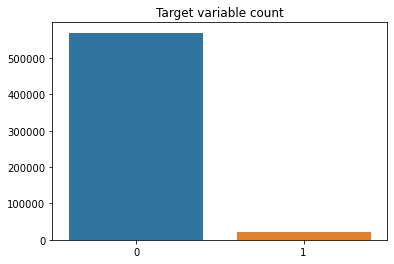

In [7]:
x = train_transactions['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

In [8]:
# merge transactions and identity
train = train_transactions.merge(train_identity, how='left', left_index=True, right_index=True)
y_train = train['isFraud'].astype('uint8')
print('Train shape', train.shape)

print("Data set merged")

Train shape (590540, 435)
Data set merged


In [9]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.82 µs


In [10]:
%%time
train = reduce_mem_usage2(train)

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 527.82 MB
Decreased by 73.1%
CPU times: user 25.1 s, sys: 25.6 s, total: 50.7 s
Wall time: 50.8 s


In [14]:
X_train,X_test,y_train,y_test=train_test_split(train.drop('isFraud',axis=1),y_train,test_size=.2,random_state=1)

ValueError: Found input variables with inconsistent numbers of samples: [590540, 472432]

In [15]:
# over sampling
X=pd.concat([X_train,y_train],axis=1)

not_fraud = X[X.isFraud==0]
fraud = X[X.isFraud==1]

#upsample minority
fraud_upsampled = resample(fraud, replace=True, n_samples = len(not_fraud), random_state=27)

#combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

#check new class counts
upsampled.isFraud.value_counts()

1    455903
0    455903
Name: isFraud, dtype: int64

Text(0, 0.5, 'count')

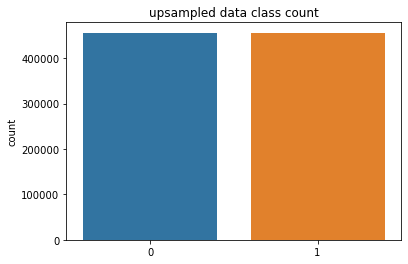

In [16]:
y=upsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('upsampled data class count')
plt.ylabel('count')

In [17]:
# undersampling
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.isFraud.value_counts()

1    16529
0    16529
Name: isFraud, dtype: int64

Text(0, 0.5, 'count')

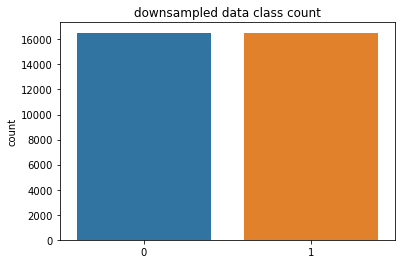

In [18]:
y=downsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('downsampled data class count')
plt.ylabel('count')

In [19]:
# test with unbalance data
lr = LogisticRegression()
lr.fit(X_train, y_train)
prob = lr.predict_proba(X_test)


ValueError: could not convert string to float: 'SM-G610M Build/NRD90M'

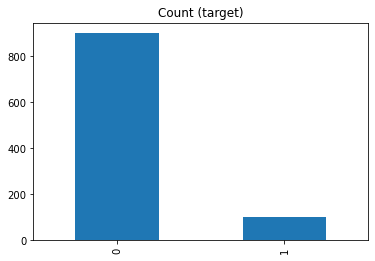

In [20]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=1000, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)')

In [21]:
def logistic(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=1)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)
    return (prob[:,1],y_test)

In [22]:
probs,y_test=logistic(X,y)

In [23]:
def plot_pre_curve(y_test,probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title("precision recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()
    
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

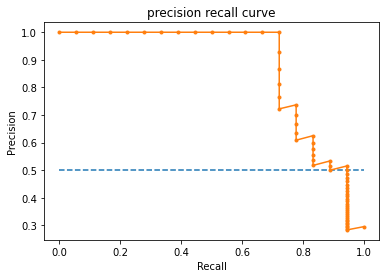

In [24]:
plot_pre_curve(y_test,probs)

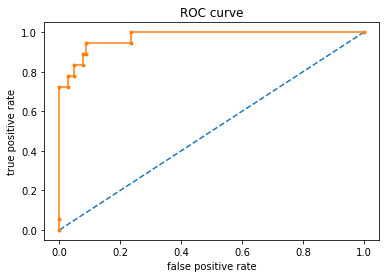

In [25]:
plot_roc(y_test,probs)

In [26]:
def plot_2d_space(X_train, y_train,X=X,y=y ,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X_train[y_train==l, 0],
            X_train[y_train==l, 1],
            c=c, label=l, marker=m
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
   
    ax1.set_title(label)
    ax2.set_title('original data')
    plt.legend(loc='upper right')
    plt.show()

In [27]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 3.1 s
PCA took 0.039 s
Truncated SVD took 0.002 s


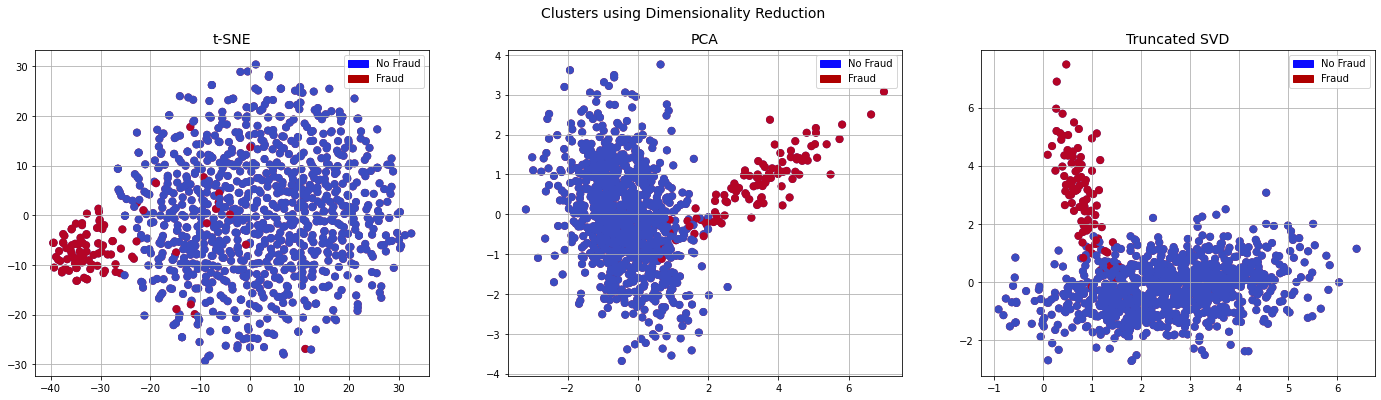

In [28]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [32]:
import imblearn

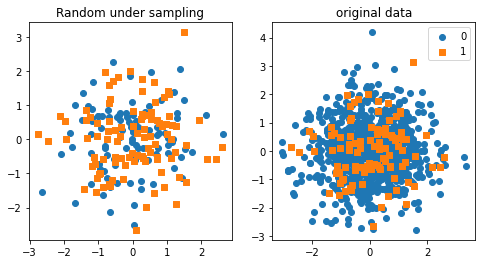

In [40]:
# random under-sampling with imbalanced-learn

from imblearn.under_sampling import RandomUnderSampler

ran=RandomUnderSampler() ##intialize to return indices of dropped rows
X_rs,y_rs = ran.fit_sample(X,y)


plot_2d_space(X_rs,y_rs,X,y,'Random under sampling')